In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd
from IPython import display

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)

last updated: 2017-04-26 
Git hash: 46dde429dab4bedbca6fc69b24c670a949be87af


In [2]:
# Notebook specific imports
from scipy.cluster.hierarchy import linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from pymongo import MongoClient

In [3]:
# Connect to DB
client = MongoClient(host='128.231.83.74', port=27022)
db = client['sra2']
ncbi = db['ncbi']
remap = db['remap']

In [4]:
# Make a list of SRRs that were annotated in SRA as being RNASeq or Transcriptomic
agg = ncbi.aggregate([
    {'$match': {'sra.db_flags': 'RNASeq'}},
    {'$unwind': '$runs'},
    {'$project': {'_id': '$runs.srr'}},
])

anno_rnaseq = [x['_id'] for x in agg]
len(anno_rnaseq)

18176

In [5]:
with open('../../data/13495_runs_analyzed_by_mieg.txt', 'r') as fh:
    mieg = [x.strip() for x in fh]

In [6]:
with open('../../data/312_sample_golden_set_2016-06-14.txt', 'r') as fh:
    golden = [x.strip() for x in fh]

In [7]:
with open('../../data/modEncode_srrs.txt', 'r') as fh:
    mod = [x.strip() for x in fh if x.strip() in anno_rnaseq]

## Gene Body Coverage

In [8]:
gb_hist = pd.read_table('../../output/prealignment/agg/se_picard_collectrnaseqmetrics_first_hist.tsv', index_col=0)

In [9]:
gb_cov = pd.read_table('../../output/prealignment/agg/se_picard_collectrnaseqmetrics_first_summary.tsv', index_col=0)

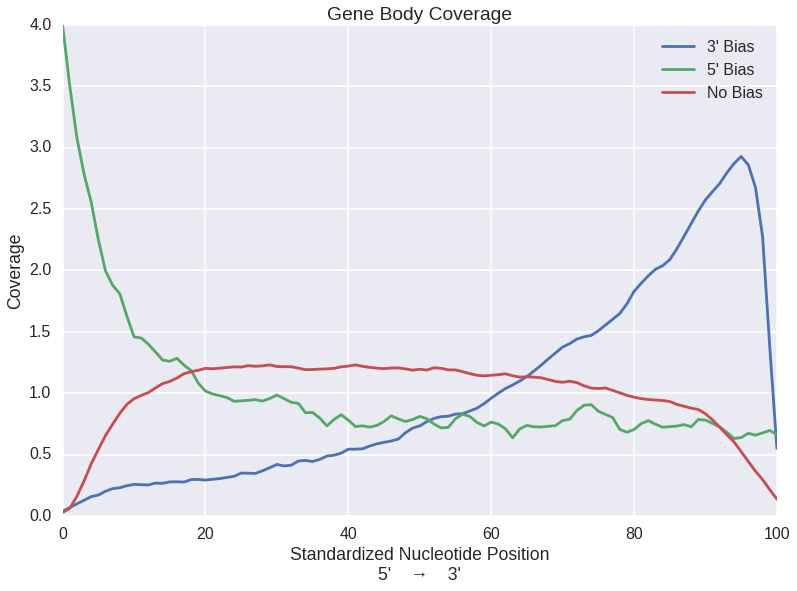

In [178]:
ax = gb_hist.loc['SRR1573832'].T.plot(label='3\' Bias')
gb_hist.loc['SRR1175642'].T.plot(label='5\' Bias', ax=ax)
gb_hist.loc['SRR2155487'].T.plot(label='No Bias', ax=ax)
ax.legend()
ax.set_title('Gene Body Coverage')
ax.set_xlabel('Standardized Nucleotide Position\n5\'    →    3\'')
ax.set_ylabel('Coverage');

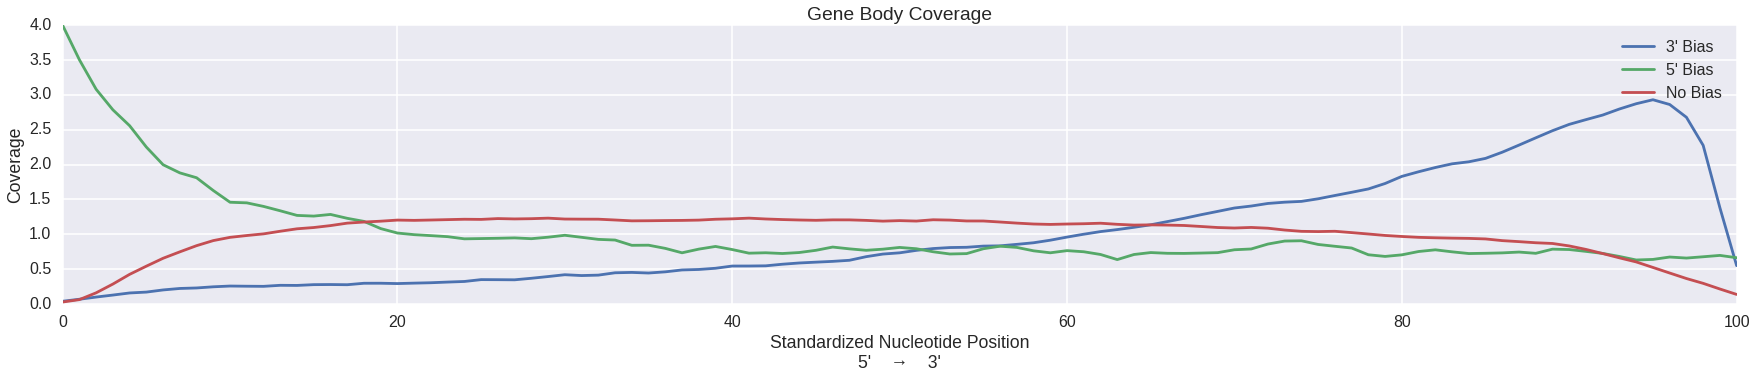

In [32]:
fig, ax = plt.subplots(1,1, figsize=(30, 5))
gb_hist.loc['SRR1573832'].T.plot(label='3\' Bias', ax=ax)
gb_hist.loc['SRR1175642'].T.plot(label='5\' Bias', ax=ax)
gb_hist.loc['SRR2155487'].T.plot(label='No Bias', ax=ax)
ax.legend()
ax.set_title('Gene Body Coverage')
ax.set_xlabel('Standardized Nucleotide Position\n5\'    →    3\'')
ax.set_ylabel('Coverage');

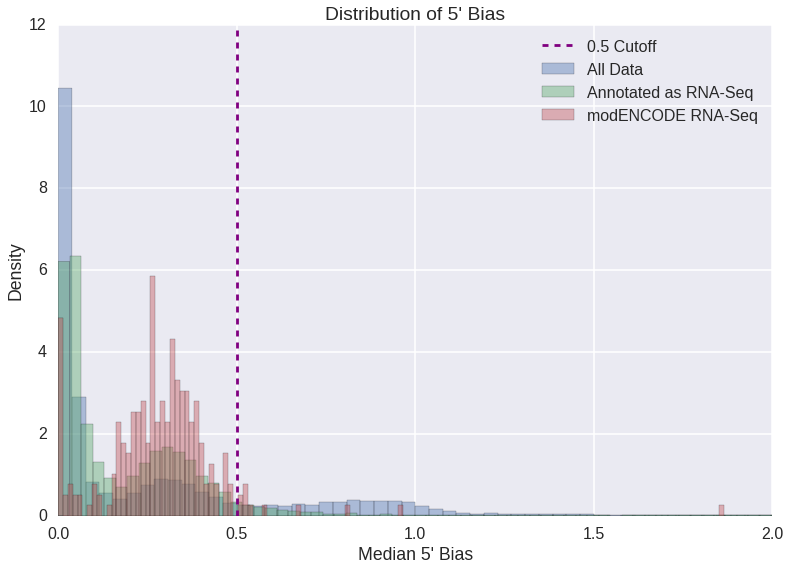

In [29]:
ax = sns.distplot(gb_cov.MEDIAN_5PRIME_BIAS, bins=500, kde=False, label='All Data', norm_hist=True)
sns.distplot(gb_cov.loc[anno_rnaseq, 'MEDIAN_5PRIME_BIAS'].dropna(), bins=500, ax=ax, kde=False, label='Annotated as RNA-Seq', norm_hist=True)
sns.distplot(gb_cov.loc[mod, 'MEDIAN_5PRIME_BIAS'].dropna(), bins=500, ax=ax, kde=False, label='modENCODE RNA-Seq', norm_hist=True)
ax.axvline(0.5, c='purple', ls='--', label='0.5 Cutoff')
ax.legend()
ax.set_xlim(0, 2)
ax.set_title('Distribution of 5\' Bias')
ax.set_xlabel('Median 5\' Bias')
ax.set_ylabel('Density');

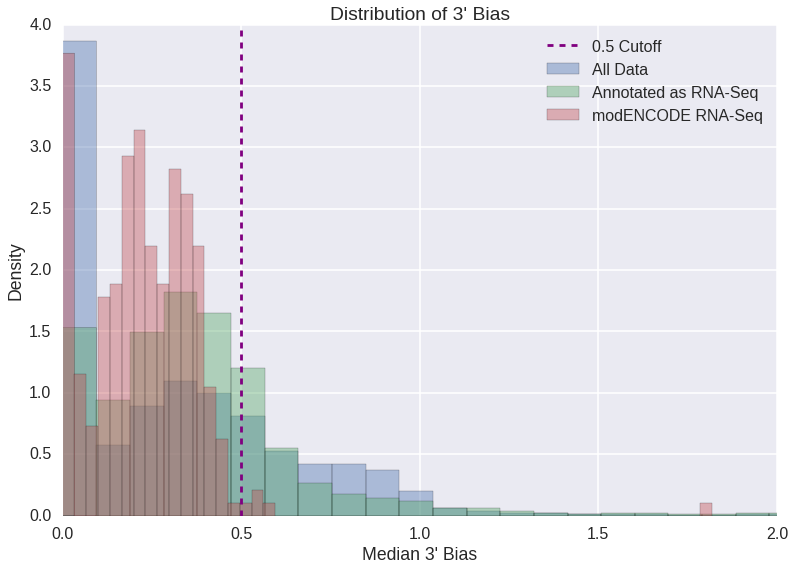

In [28]:
ax = sns.distplot(gb_cov.MEDIAN_3PRIME_BIAS, bins=500, kde=False, label='All Data', norm_hist=True)
sns.distplot(gb_cov.loc[anno_rnaseq, 'MEDIAN_3PRIME_BIAS'].dropna(), bins=500, ax=ax, kde=False, label='Annotated as RNA-Seq', norm_hist=True)
sns.distplot(gb_cov.loc[mod, 'MEDIAN_3PRIME_BIAS'].dropna(), bins=200, ax=ax, kde=False, label='modENCODE RNA-Seq', norm_hist=True)
ax.axvline(0.5, c='purple', ls='--', label='0.5 Cutoff')
ax.legend()
ax.set_xlim(0, 2)
ax.set_title('Distribution of 3\' Bias')
ax.set_xlabel('Median 3\' Bias')
ax.set_ylabel('Density');

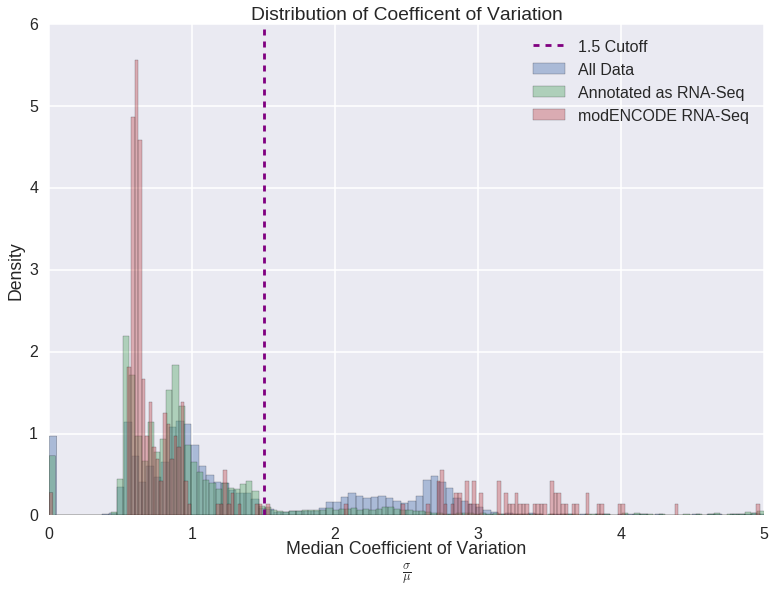

In [348]:
ax = sns.distplot(gb_cov.MEDIAN_CV_COVERAGE, bins=500, kde=False, label='All Data', norm_hist=True)
sns.distplot(gb_cov.loc[anno_rnaseq, 'MEDIAN_CV_COVERAGE'].dropna(), bins=500, ax=ax, kde=False, label='Annotated as RNA-Seq', norm_hist=True)
sns.distplot(gb_cov.loc[mod, 'MEDIAN_CV_COVERAGE'].dropna(), bins=200, ax=ax, kde=False, label='modENCODE RNA-Seq', norm_hist=True)
ax.axvline(1.5, c='purple', ls='--', label='1.5 Cutoff')
ax.legend()
ax.set_xlim(0, 5)
ax.set_title('Distribution of Coefficent of Variation')
ax.set_xlabel('Median Coefficient of Variation\n' + r'$\frac{\sigma}{\mu}$')
ax.set_ylabel('Density');

In [208]:
ok = gb_cov[(gb_cov['MEDIAN_5PRIME_BIAS'] < .5) & (gb_cov['MEDIAN_3PRIME_BIAS'] < .5) & (gb_cov['MEDIAN_CV_COVERAGE'] <= 1.5)].index.tolist()

In [211]:
len(ok)

22740

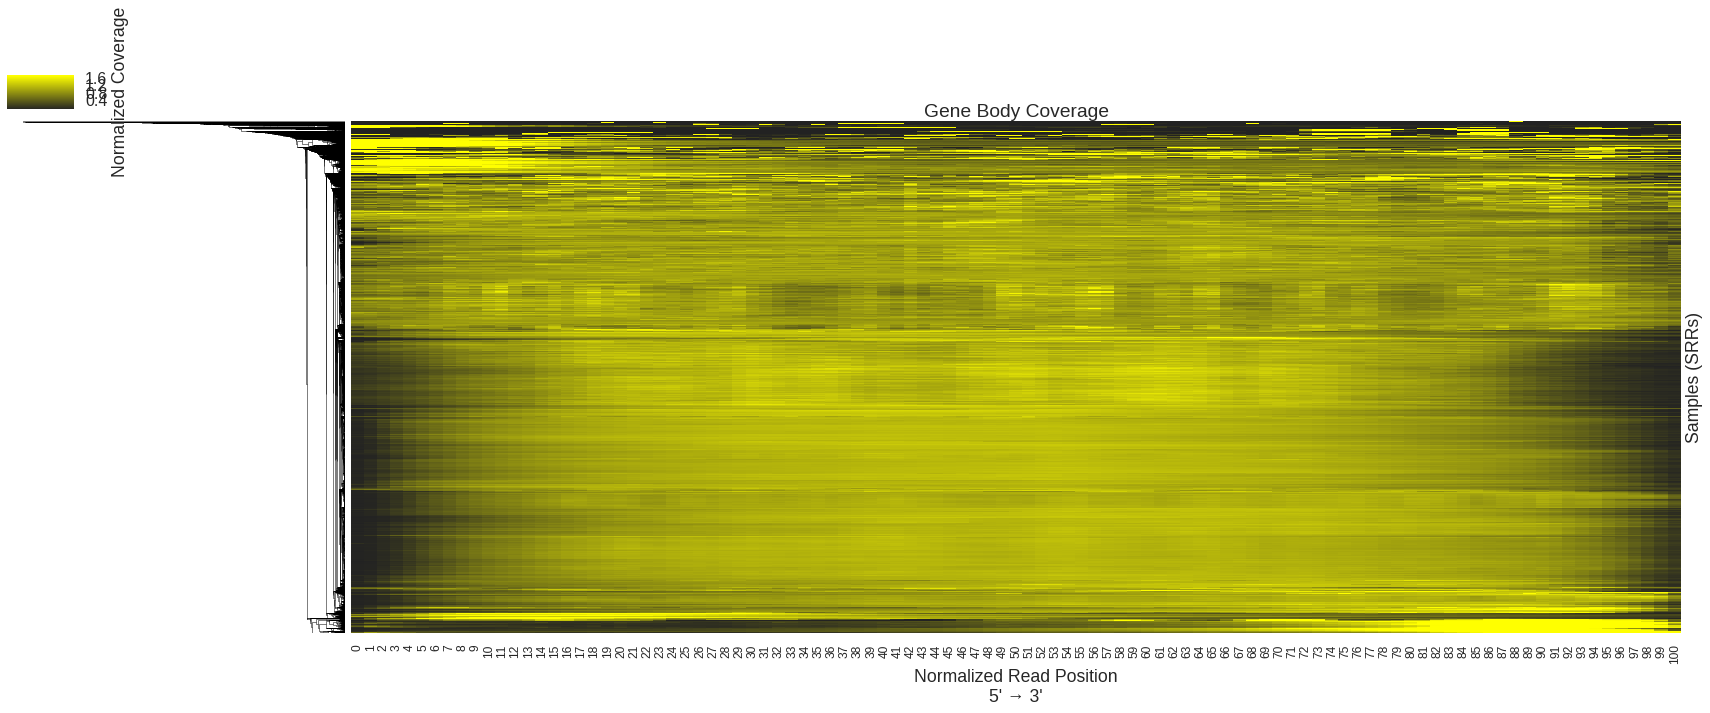

In [235]:
ax = sns.clustermap(gb_hist, col_cluster=False, yticklabels=False, 
                    cmap=sns.dark_palette('yellow', as_cmap=True), robust=True, 
                    cbar_kws={'label': 'Normalized Coverage'}, figsize=(30, 10),
                   )

labels = ax.ax_heatmap.get_xticklabels()
for l in labels:
    l.set_fontsize(12)
    
ax.ax_heatmap.set_title('Gene Body Coverage')
ax.ax_heatmap.set_ylabel('Samples (SRRs)');
ax.ax_heatmap.set_xlabel('Normalized Read Position\n5\' → 3\'');

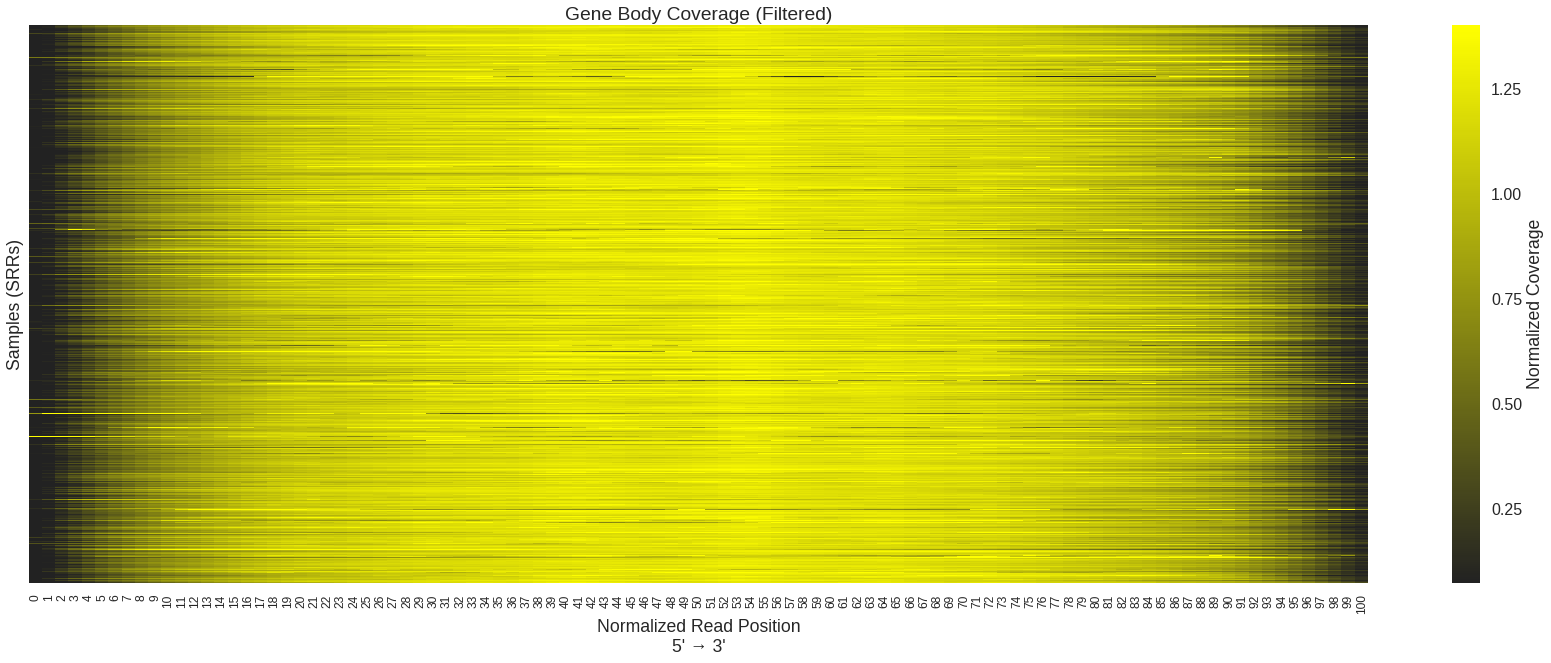

In [237]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
sns.heatmap(gb_hist.loc[ok], yticklabels=False,  cmap=sns.dark_palette('yellow', as_cmap=True), robust=True, 
                    cbar_kws={'label': 'Normalized Coverage'}, ax=ax)

labels = ax.get_xticklabels()
for l in labels:
    l.set_fontsize(12)
    
ax.set_title('Gene Body Coverage (Filtered)')
ax.set_ylabel('Samples (SRRs)');
ax.set_xlabel('Normalized Read Position\n5\' → 3\'');

In [243]:
background = gb_cov.index.tolist()

In [366]:
len(background)

22740

In [246]:
gb_anno = [x for x in anno_rnaseq if x in background]

In [248]:
dT = pd.DataFrame(index=pd.Index(background))

In [286]:
dT.loc[gb_anno, 'RNA-Seq Annotation'] = True
dT.loc[ok, 'Pass Filter'] = True
dT.loc[[x for x in mieg if x in background], 'Mieg'] = True
dT.loc[[x for x in golden if x in background], 'Golden'] = True
dT.fillna(False, inplace=True)

In [293]:
ct = pd.crosstab(dT['RNA-Seq Annotation'], dT['Golden'])
oddsRatio, pvalue = fisher_exact(ct)
display.display(ct.applymap(lambda x: '{:,}'.format(x)))
print('Fisher\'s exact p-value: {:.4}'.format(pvalue))
print('Fisher\'s exact odds ratio: {:.4}'.format(oddsRatio))

Golden,False,True
RNA-Seq Annotation,,
False,"10,839",0
True,"11,755",146


Fisher's exact p-value: 1.017e-41
Fisher's exact odds ratio: inf


In [291]:
ct = pd.crosstab(dT['RNA-Seq Annotation'], dT['Mieg'])
oddsRatio, pvalue = fisher_exact(ct)
display.display(ct.applymap(lambda x: '{:,}'.format(x)))
print('Fisher\'s exact p-value: {:.4}'.format(pvalue))
print('Fisher\'s exact odds ratio: {:.4}'.format(oddsRatio))

Mieg,False,True
RNA-Seq Annotation,,
False,"10,807",32
True,"3,310","8,591"


Fisher's exact p-value: 0.0
Fisher's exact odds ratio: 876.5


In [285]:
ct = pd.crosstab(dT['RNA-Seq Annotation'], dT['Pass Filter'])
oddsRatio, pvalue = fisher_exact(ct)
display.display(ct.applymap(lambda x: '{:,}'.format(x)))
print('Fisher\'s exact p-value: {:.4}'.format(pvalue))
print('Fisher\'s exact odds ratio: {:.4}'.format(oddsRatio))

Pass Filter,False,True
RNA-Seq Annotation,,
False,"9,891",948
True,"4,757","7,144"


Fisher's exact p-value: 0.0
Fisher's exact odds ratio: 15.67


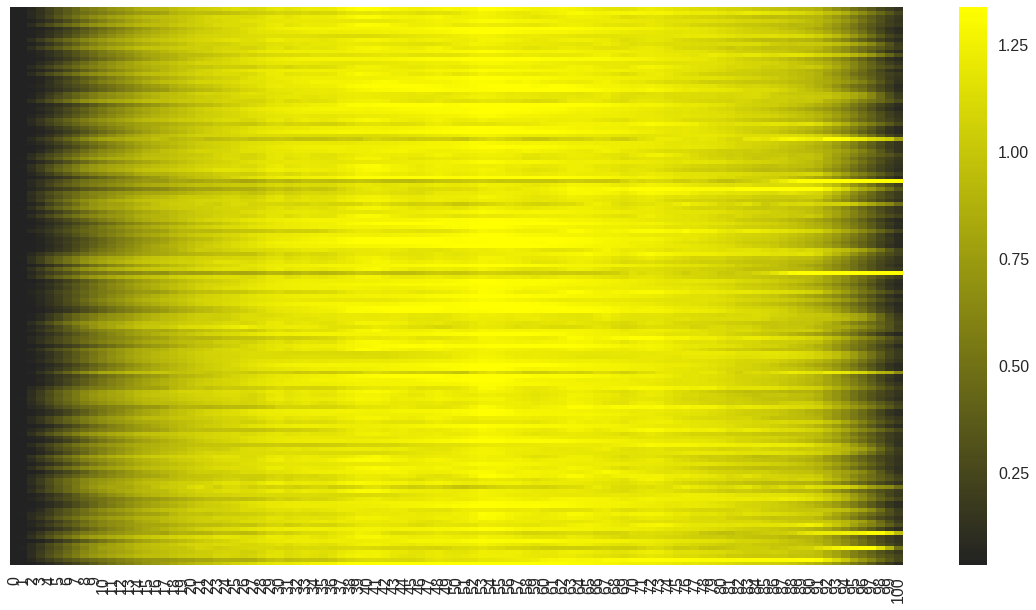

In [188]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(gb_hist[gb_hist.index.isin(golden)], yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), robust=True)

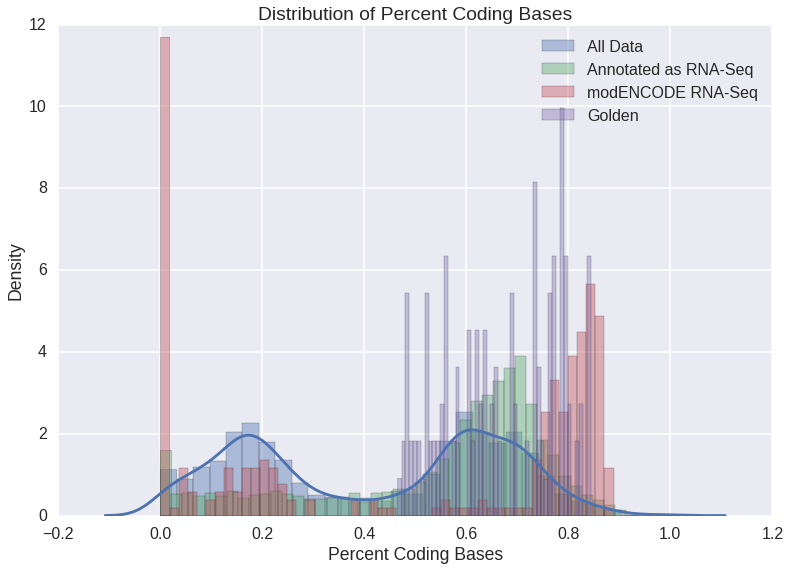

In [349]:
ax = sns.distplot(gb_cov.PCT_CODING_BASES, norm_hist=True, label='All Data')
sns.distplot(gb_cov.loc[anno_rnaseq, 'PCT_CODING_BASES'].dropna(), ax=ax, kde=False, label='Annotated as RNA-Seq', norm_hist=True)
sns.distplot(gb_cov.loc[mod, 'PCT_CODING_BASES'].dropna(), ax=ax, bins=50, kde=False, label='modENCODE RNA-Seq', norm_hist=True)
ax.legend()
ax.set_title('Distribution of Percent Coding Bases')
ax.set_xlabel('Percent Coding Bases')
ax.set_ylabel('Density');

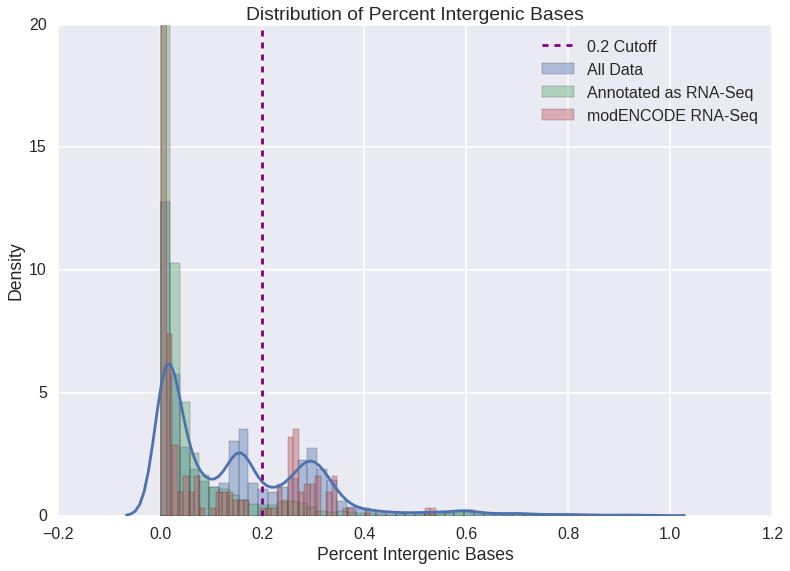

In [22]:

ax = sns.distplot(gb_cov.PCT_INTERGENIC_BASES, norm_hist=True, label='All Data')
sns.distplot(gb_cov.loc[anno_rnaseq, 'PCT_INTERGENIC_BASES'].dropna(), ax=ax, kde=False, label='Annotated as RNA-Seq', norm_hist=True)
sns.distplot(gb_cov.loc[mod, 'PCT_INTERGENIC_BASES'].dropna(), ax=ax, bins=50, kde=False, label='modENCODE RNA-Seq', norm_hist=True)
ax.axvline(0.2, c='purple', ls='--', label='0.2 Cutoff')
ax.legend()
ax.set_ylim(0, 20)
ax.set_title('Distribution of Percent Intergenic Bases')
ax.set_xlabel('Percent Intergenic Bases')
ax.set_ylabel('Density');

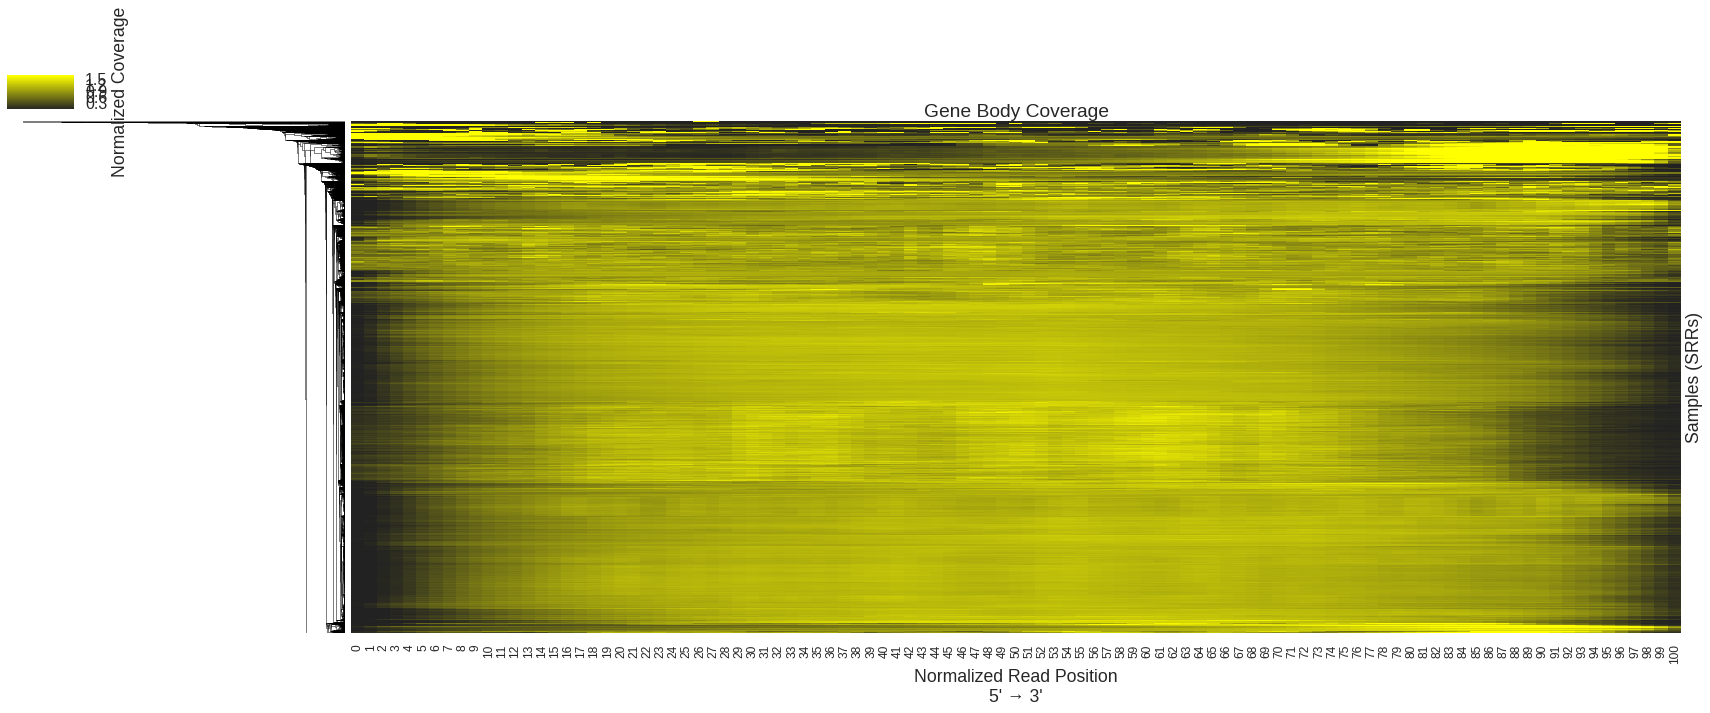

In [20]:
intGen = gb_cov[(gb_cov.PCT_INTERGENIC_BASES < 0.20)].index.tolist()

ax = sns.clustermap(gb_hist[gb_hist.index.isin(intGen)], col_cluster=False, yticklabels=False, 
                    cmap=sns.dark_palette('yellow', as_cmap=True), robust=True, 
                    cbar_kws={'label': 'Normalized Coverage'}, figsize=(30, 10),
                   )

labels = ax.ax_heatmap.get_xticklabels()
for l in labels:
    l.set_fontsize(12)
    
ax.ax_heatmap.set_title('Gene Body Coverage')
ax.ax_heatmap.set_ylabel('Samples (SRRs)');
ax.ax_heatmap.set_xlabel('Normalized Read Position\n5\' → 3\'');

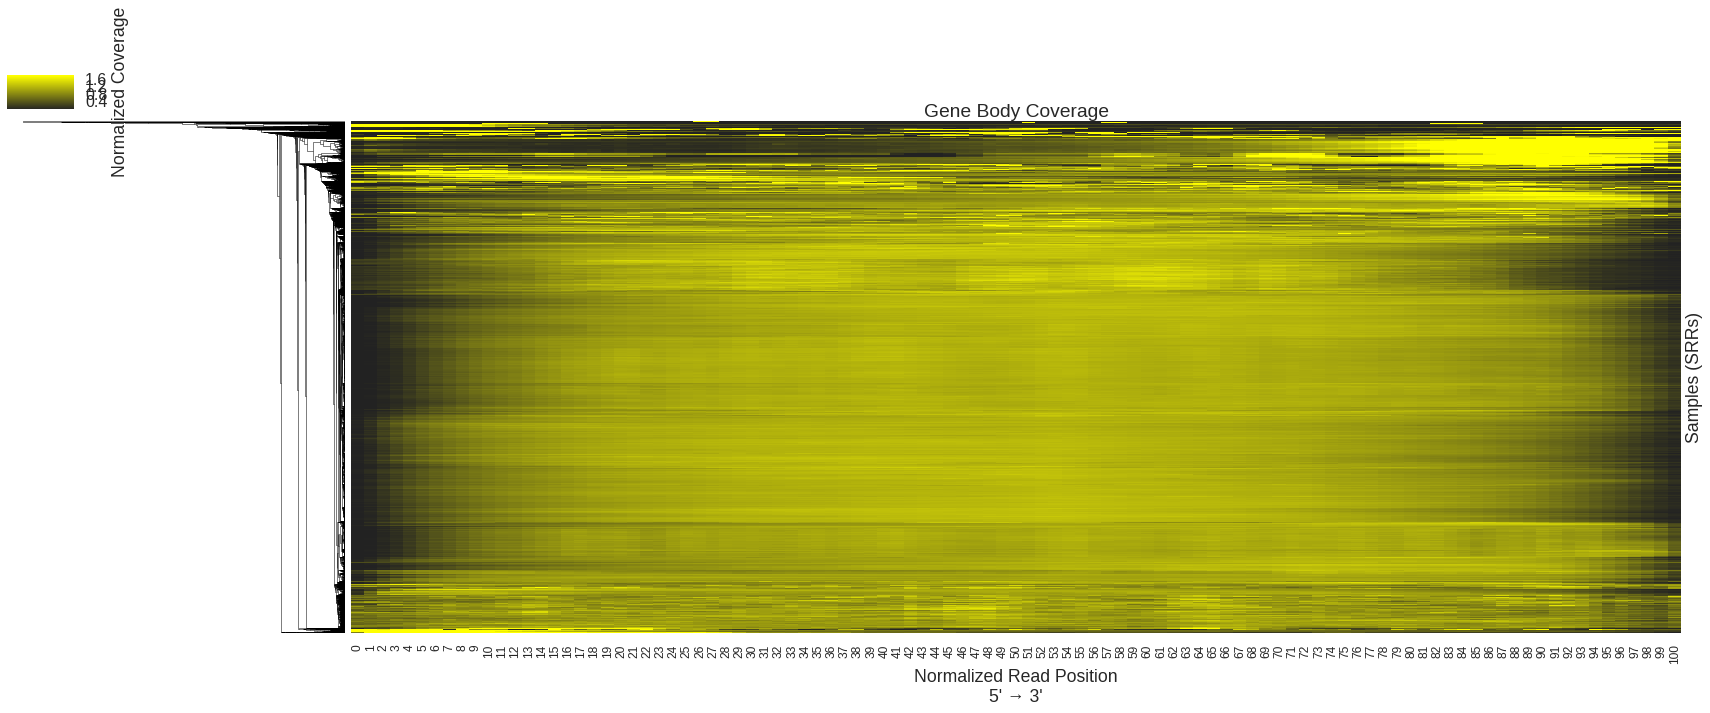

In [16]:
intGen = gb_cov[(gb_cov.PCT_INTERGENIC_BASES < 0.15)].index.tolist()

ax = sns.clustermap(gb_hist[gb_hist.index.isin(intGen)], col_cluster=False, yticklabels=False, 
                    cmap=sns.dark_palette('yellow', as_cmap=True), robust=True, 
                    cbar_kws={'label': 'Normalized Coverage'}, figsize=(30, 10),
                   )

labels = ax.ax_heatmap.get_xticklabels()
for l in labels:
    l.set_fontsize(12)
    
ax.ax_heatmap.set_title('Gene Body Coverage')
ax.ax_heatmap.set_ylabel('Samples (SRRs)');
ax.ax_heatmap.set_xlabel('Normalized Read Position\n5\' → 3\'');

In [339]:
dT.drop('Pass Intergenic Cutoff', axis=1, inplace=True)

In [340]:
dT.loc[intGen, 'Pass Intergenic Cutoff'] = True
dT.fillna(False, inplace=True)

In [341]:
ct = pd.crosstab(dT['Golden'], dT['Pass Intergenic Cutoff'])
oddsRatio, pvalue = fisher_exact(ct)
display.display(ct.applymap(lambda x: '{:,}'.format(x)))
print('Fisher\'s exact p-value: {:.4}'.format(pvalue))
print('Fisher\'s exact OR: {:.4}'.format(oddsRatio))

Pass Intergenic Cutoff,False,True
Golden,,
False,"9,875","12,719"
True,0,146


Fisher's exact p-value: 6.388e-37
Fisher's exact OR: inf


In [342]:
dT.columns

Index(['RNA-Seq Annotation', 'Pass Filter', 'Mieg', 'Golden',
       'Pass Intergenic Cutoff'],
      dtype='object')

In [335]:
ct = pd.crosstab(dT['Golden'], dT['Pass Intergenic Cutoff'])
oddsRatio, pvalue = fisher_exact(ct)
display.display(ct.applymap(lambda x: '{:,}'.format(x)))
print('Fisher\'s exact p-value: {:.4}'.format(pvalue))
print('Fisher\'s exact OR: {:.4}'.format(oddsRatio))

Pass Intergenic Cutoff,False,True
Golden,,
False,"13,796","8,798"
True,37,109


Fisher's exact p-value: 2.885e-18
Fisher's exact OR: 4.619


In [336]:
ct = pd.crosstab(dT['Golden'], dT['Pass Filter'])
oddsRatio, pvalue = fisher_exact(ct)
display.display(ct.applymap(lambda x: '{:,}'.format(x)))
print('Fisher\'s exact p-value: {:.4}'.format(pvalue))
print('Fisher\'s exact OR: {:.4}'.format(oddsRatio))

Pass Filter,False,True
Golden,,
False,"14,624","7,970"
True,24,122


Fisher's exact p-value: 6.276e-33
Fisher's exact OR: 9.327


In [355]:
ct = pd.crosstab(dT['Mieg'], dT['Pass Intergenic Cutoff'])
oddsRatio, pvalue = fisher_exact(ct)
display.display(ct.applymap(lambda x: '{:,}'.format(x)))
print('Fisher\'s exact p-value: {:.4}'.format(pvalue))
print('Fisher\'s exact OR: {:.4}'.format(oddsRatio))

Pass Intergenic Cutoff,False,True
Mieg,,
False,"8,561","5,556"
True,"1,314","7,309"


Fisher's exact p-value: 0.0
Fisher's exact OR: 8.571


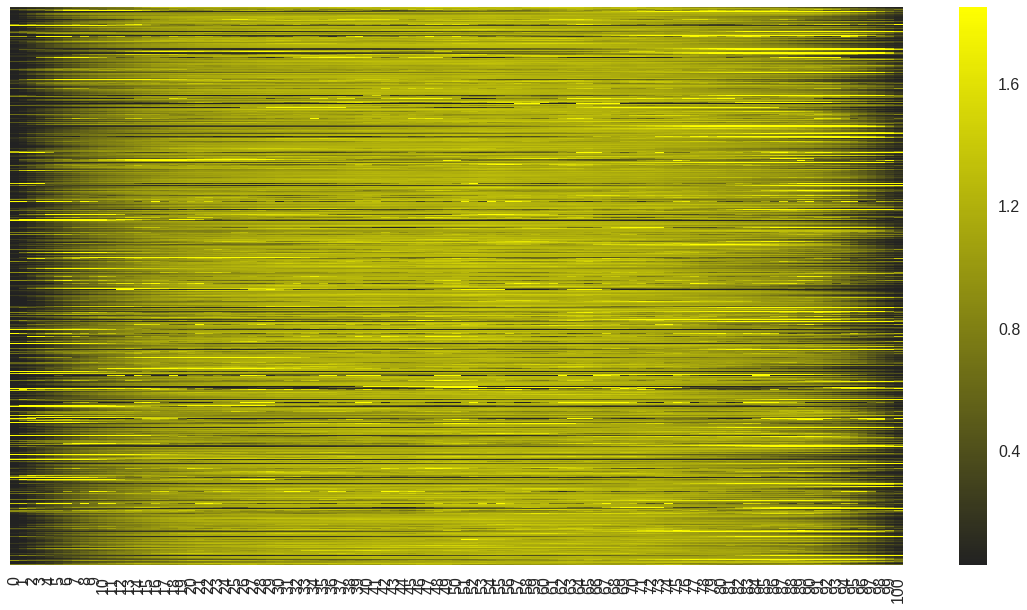

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(gb_hist[gb_hist.index.isin(intGen)], yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), robust=True)

In [7]:
# Clusters samples using gene body coverage
row_linkage = linkage(gb_cov, 'average')
c, _ = cophenet(row_linkage, pdist(gb_cov))
print('The cophenet score is: {}'.format(c))

# calculate tree
clusters = fcluster(row_linkage, 10, 'maxclust')

The cophenet score is: 0.9812860248324777


In [10]:
X = StandardScaler().fit_transform(gb_cov)

In [11]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)

In [12]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [40]:
# Trun into DF and make color pallet
clustDf= pd.DataFrame(clusters, index=gb_cov.index, columns=['cluster'])

# Mapp colors to clusters
pal = sns.husl_palette(n_colors=10)
mapper = {k: v for k, v in zip(range(1, 11), pal)}
colors = clustDf['cluster'].map(lambda x: mapper[x]).to_frame()

# map colors to annotation
r, b = sns.xkcd_palette(['red', 'blue'])
colors['annotation'] = [b]*colors.shape[0]
colors.loc[colors.index.isin(anno_rnaseq), 'annotation'] = [r]

# map colors to bias
g, c = sns.xkcd_palette(['green', 'cyan'])
colors['bias'] = [c]*colors.shape[0]
colors.loc[colors.index.isin(noBias), 'bias'] = [g]

# map colors to dbscan
ccs = sns.cubehelix_palette(n_colors=10)
blk = sns.xkcd_palette(['black'])
colors['dbscan'] = blk * colors.shape[0]
for l, c in zip(set(labels), ccs):
    if l == '-1':
        c = blk
    colors.loc[labels == l, 'dbscan'] = [c]

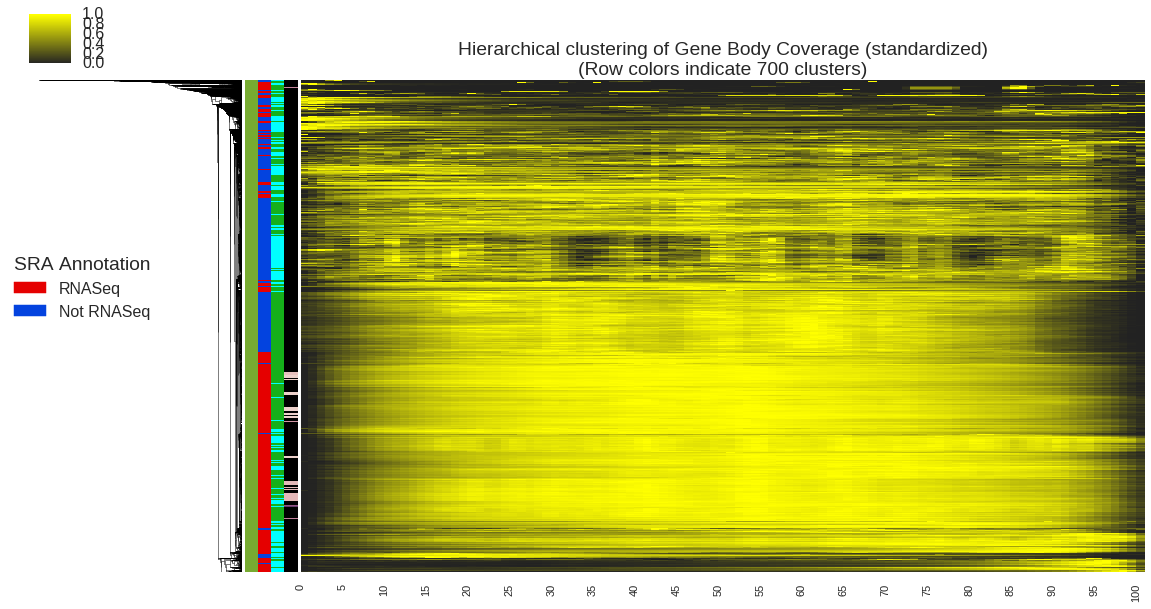

In [41]:
# Draw Heatmap
clust = sns.clustermap(gb_cov, 
               row_linkage=row_linkage, 
               col_cluster=False, 
               yticklabels=False,
               standard_scale=0,
               cmap=sns.dark_palette('yellow', as_cmap=True),
               row_colors=colors,
               figsize=(20, 10)
              )
clust.ax_heatmap.set_title('Hierarchical clustering of Gene Body Coverage (standardized)\n(Row colors indicate 700 clusters)')
clust.ax_heatmap.xaxis.set_ticks(range(0, 101, 5))
clust.ax_heatmap.xaxis.set_ticklabels(range(0, 101, 5), fontsize=11)
clust.ax_row_colors.xaxis.set_visible(False)
hr = mpl.patches.Patch(color=r)
hb = mpl.patches.Patch(color=b)
clust.ax_row_dendrogram.legend([hr, hb], ['RNASeq', 'Not RNASeq'], title="SRA Annotation", loc=(-0.1, .5), bbox_transform=clust.ax_row_dendrogram.transAxes);

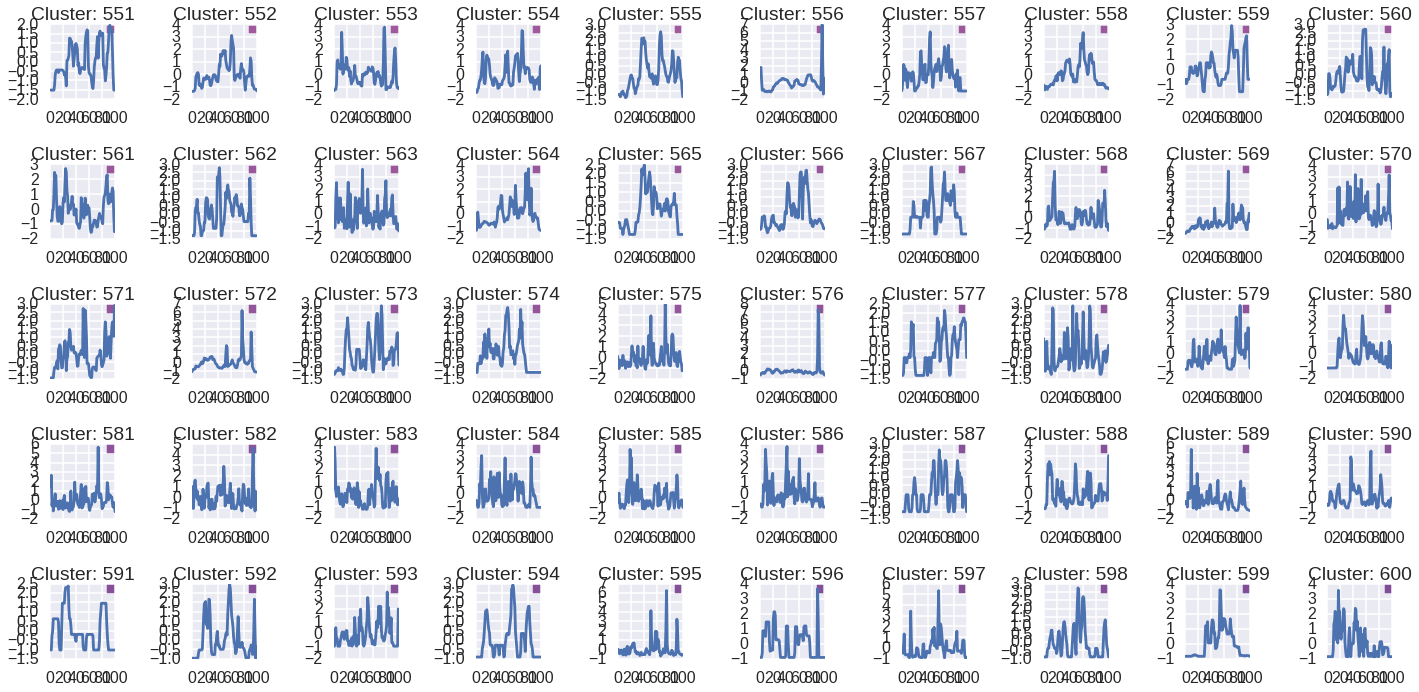

In [79]:
# Plot density graphs of coverage by cluster
norm = gb_cov.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = np.ravel(axes)
for g, d in clustDf.reset_index().groupby('cluster'):
    if 550 < g < 601:
        ax = axes[g-551]
        ax.add_patch(plt.Rectangle((.88,.88), .1, .1, color=mapper[g], transform=ax.transAxes))
        norm.loc[d['index']].T.plot(legend=False, ax=ax, title='Cluster: {}'.format(g))
plt.tight_layout()

In [387]:
agg = ncbi.aggregate([
    {'$unwind': '$runs'}, 
    {
        '$match': {
            'sra.run.nreads': 1,
        }
    }, 
    {'$project': {'srr': '$runs.srr'}}
])
    
ncbi_se = []
for srr in agg:
    ncbi_se.append(srr['srr'])

In [388]:
agg = ncbi.aggregate([
    {'$unwind': '$runs'}, 
    {
        '$match': {
            'sra.run.nreads': 2,
        }
    }, 
    {'$project': {'srr': '$runs.srr'}}
])
    
ncbi_pe = []
for srr in agg:
    ncbi_pe.append(srr['srr'])

In [389]:
agg = ncbi.aggregate([
    {'$unwind': '$runs'}, 
    {
        '$match': {
            'sra.run.nreads': 2,
            '$or': [
                {'sra.run.read_len_r1': {'$lte': 10}},
                {'sra.run.read_len_r2': {'$lte': 10}},
            ]
        }}, 
    {'$project': {'srr': '$runs.srr'}}
])
    
pe_short = []
for srr in agg:
    pe_short.append(srr['srr'])

In [390]:
len(pe_short)

373

In [453]:
agg = remap.aggregate([
    {'$unwind': '$runs'}, 
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
                {'$or': [
                    {'runs.pre_aln_flags': 'SE'},
                    {'runs.pre_aln_flags': 'PE'},
                ]}
            ]
        }
    }, 
    {'$group': {'_id': '$runs.srr'}},
    {'$project': {'srr': '$srx'}}
])
    
remap_analyzed = []
for srr in agg:
    remap_analyzed.append(srr['srr'])

In [455]:
agg = remap.aggregate([
    {'$unwind': '$runs'}, 
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
                {'runs.pre_aln_flags': 'SE'},
            ]
        }
    }, 
    {'$project': {'srr': '$runs.srr'}}
])
    
remap_se = []
for srr in agg:
    remap_se.append(srr['srr'])

In [457]:
agg = remap.aggregate([
    {'$unwind': '$runs'}, 
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
                {'runs.pre_aln_flags': 'PE'},
            ]
        }
    }, 
    {'$project': {'srr': '$runs.srr'}}
])
    
remap_pe = []
for srr in agg:
    remap_pe.append(srr['srr'])

In [460]:
ncbi_se = [x for x in ncbi_se if x in remap_analyzed]
ncbi_pe = [x for x in ncbi_pe if x in remap_analyzed]

In [461]:
dt = pd.DataFrame(index=pd.Index(remap_analyzed))

In [462]:
dt.loc[ncbi_pe, 'ncbi_pe'] = True
dt.loc[ncbi_se, 'ncbi_se'] = True
dt.loc[remap_se, 'remap_se'] = True
dt.loc[remap_pe, 'remap_pe'] = True
dt.fillna(False, inplace=True)

In [463]:
ct = pd.crosstab(dt['ncbi_se'], dt['remap_se'])
odds, pvalue = fisher_exact(ct)
display.display(ct.applymap(lambda x: '{:,}'.format(x)))
print(odds)
print(pvalue)

remap_se,False,True
ncbi_se,,
False,"9,257",495
True,0,"22,245"


inf
0.0


In [471]:
len(ncbi_se)- len(remap_se)

-495

In [472]:
ct = pd.crosstab(dt['ncbi_pe'], dt['remap_pe'])
odds, pvalue = fisher_exact(ct)
display.display(ct.applymap(lambda x: '{:,}'.format(x)))
print(odds)
print(pvalue)

remap_pe,False,True
ncbi_pe,,
False,"22,247",29
True,493,"9,228"


14359.3282507
0.0


In [474]:
len(ncbi_pe)- len(remap_pe)

464

In [466]:
dt.shape

(31997, 4)

In [467]:
ct = pd.crosstab(dt['ncbi_se'], dt['remap_pe'])
odds, pvalue = fisher_exact(ct)
display.display(ct.applymap(lambda x: '{:,}'.format(x)))
print(odds)
print(pvalue)

remap_pe,False,True
ncbi_se,,
False,495,"9,257"
True,"22,245",0


0.0
0.0


In [468]:
ct = pd.crosstab(dt['ncbi_pe'], dt['remap_se'])
odds, pvalue = fisher_exact(ct)
display.display(ct.applymap(lambda x: '{:,}'.format(x)))
print(odds)
print(pvalue)

remap_se,False,True
ncbi_pe,,
False,29,"22,247"
True,"9,228",493


6.96411407652e-05
0.0


In [424]:
ct = pd.crosstab(dt['ncbi_pe'], dt['remap_pe'])
odds, pvalue = fisher_exact(ct)
display.display(ct.applymap(lambda x: '{:,}'.format(x)))
print(odds)
print(pvalue)

remap_pe,False,True
ncbi_pe,,
False,"22,739",29
True,543,"9,228"


13325.4265574
0.0


In [363]:
remap.find({'runs.pre_aln_flags': 'complete', 'runs.pre_aln_flags': 'first_strand'}).count()

2189

In [364]:
remap.find({'runs.pre_aln_flags': 'complete', 'runs.pre_aln_flags': 'second_strand'}).count()

5197

In [365]:
remap.find({'runs.pre_aln_flags': 'complete', 'runs.pre_aln_flags': 'unstranded'}).count()

17322

In [33]:
!ls ../../output/prealignment/agg/

pe_atropos.tsv
pe_bamStat.tsv
pe_bamtools_stats.tsv
pe_fastqc_adapter_content.tsv
pe_fastqc_basic_stats.tsv
pe_fastqc_kmer_content.tsv
pe_fastqc_overrepresented_seq.tsv
pe_fastqc_per_base_n_content.tsv
pe_fastqc_per_base_seq_content.tsv
pe_fastqc_per_base_seq_quality.tsv
pe_fastqc_per_seq_gc_content.tsv
pe_fastqc_per_seq_quality.tsv
pe_fastqc_seq_dup_level.tsv
pe_fastqc_sequence_length.tsv
pe_fastq_screen.tsv
pe_feature_counts_summary_first.tsv
pe_feature_counts_summary_second.tsv
pe_hisat2.tsv
pe_inferExperiment.tsv
pe_picard_collectrnaseqmetrics_first_hist.tsv
pe_picard_collectrnaseqmetrics_first_summary.tsv
pe_picard_markduplicates.tsv
pe_samtools_idxstats.tsv
pe_samtools_stats.tsv
se_atropos_libsize.tsv
se_atropos.tsv
se_bamStat.tsv
se_bamtools_stats.tsv
se_fastqc_adapter_content.tsv
se_fastqc_basic_stats.tsv
se_fastqc_kmer_content.tsv
se_fastq_clean_libsize.tsv
se_fastqc_overrepresented_seq.tsv
se_fastqc_per_base_n_content.tsv
se_fastqc_per_base_seq_content.tsv
se_fastqc_per_base_

In [45]:
pd.options.display.max_columns=999

In [43]:
tam = pd.read_table('../../output/prealignment/agg/se_fastq_screen.tsv', header=[0,1,2], index_col=0)
tam.columns = pd.MultiIndex.from_tuples(tam.columns)

In [46]:
tam.head()

adapters                                    \
           multiple_hits_multiple_libraries         multiple_hits_one_library   
                                      count percent                     count   
SRR1988953                               28    0.12                         0   
SRR2120657                             1423    1.42                         0   
ERR268481                                 2    0.00                         0   
SRR2628113                              462    0.46                         0   
SRR1990126                               76    0.27                         0   

                                                                           \
                   one_hit_multiple_libraries         one_hit_one_library   
           percent                      count percent               count   
SRR1988953     0.0                          0     0.0                   0   
SRR2120657     0.0                          0     0.0                   0   
ERR268481      0.0                          0     0.0                   0   
SRR2628113     0.0                          0     0.0                   0   
SRR1990126     0.0                          0     0.0                   0   

                                                     \
                   reads_processed unmapped           
           percent           count    count percent   
SRR1988953     0.0           22628    22600   99.88   
SRR2120657     0.0          100000    98577   98.58   
ERR268481      0.0          104051   104049  100.00   
SRR2628113     0.0          100000    99538   99.54   
SRR1990126     0.0           28006    27930   99.73   

                                        dm6                                    \
           multiple_hits_multiple_libraries         multiple_hits_one_library   
                                      count percent                     count   
SRR1988953                            658.0    2.91                    1518.0   
SRR2120657                           2257.0    2.26                    2003.0   
ERR268481                            3554.0    3.42                   15922.0   
SRR2628113                           1056.0    1.06                    3448.0   
SRR1990126                           2377.0    8.49                    1844.0   

                                                                           \
                   one_hit_multiple_libraries         one_hit_one_library   
           percent                      count percent               count   
SRR1988953    6.71                       80.0    0.35             19291.0   
SRR2120657    2.00                      212.0    0.21             21951.0   
ERR268481    15.30                      157.0    0.15             62248.0   
SRR2628113    3.45                      254.0    0.25             85955.0   
SRR1990126    6.58                      103.0    0.37             22164.0   

                                                     \
                   reads_processed unmapped           
           percent           count    count percent   
SRR1988953   85.25         22628.0   1081.0    4.78   
SRR2120657   21.95        100000.0  73577.0   73.58   
ERR268481    59.82        104051.0  22170.0   21.31   
SRR2628113   85.95        100000.0   9287.0    9.29   
SRR1990126   79.14         28006.0   1518.0    5.42   

                                      ecoli                                    \
           multiple_hits_multiple_libraries         multiple_hits_one_library   
                                      count percent                     count   
SRR1988953                                0     0.0                         0   
SRR2120657                                0     0.0                         0   
ERR268481                                 3     0.0                       273   
SRR2628113                                0     0.0                         0   
SRR1990126                                1     0.0   

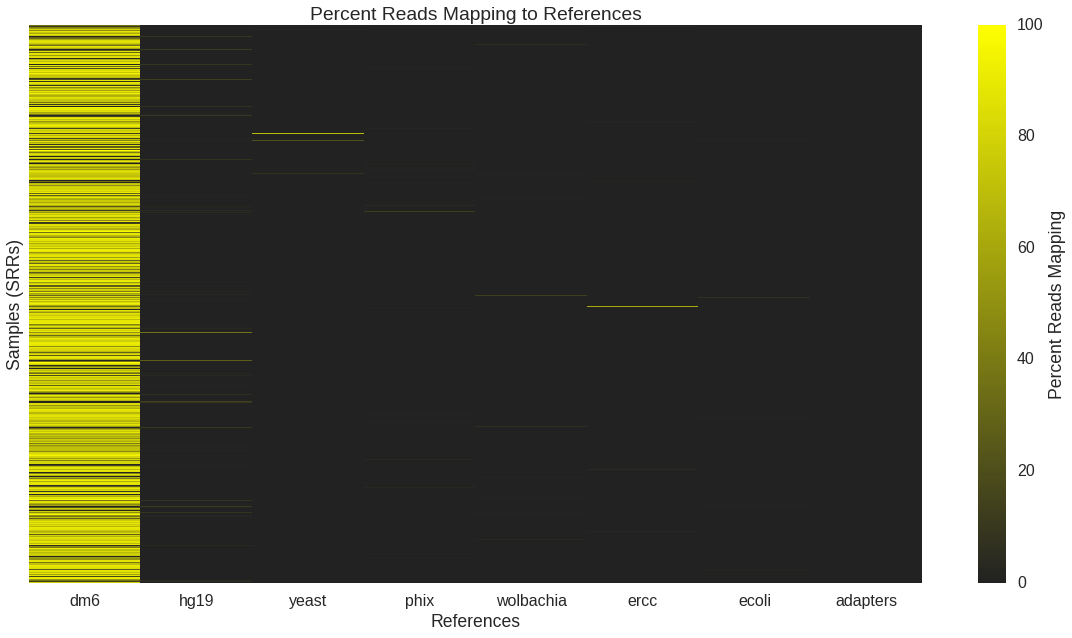

In [77]:
tam_filter = tam.loc[:, (slice(None), ['one_hit_one_library'], ['percent'])].copy()
tam_filter.columns = tam_filter.columns.droplevel(level=(1,2))

tam_filter = tam_filter[['dm6', 'hg19', 'yeast', 'phix', 'wolbachia', 'ercc', 'ecoli', 'adapters']]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(tam_filter, yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), ax=ax, cbar_kws={'label': 'Percent Reads Mapping'})
ax.set_title('Percent Reads Mapping to References')
ax.set_xlabel('References')
ax.set_ylabel('Samples (SRRs)');